# Rapid microbial interaction network inference in microfluidic droplets
## Ryan H. Hsu, Ryan L. Clark, Jin Wen Tan, Philip A. Romero & Ophelia S. Venturelli

## Supplementary Model Code
#### April 10, 2019

In [7]:
import numpy as np
from numpy.random import multinomial
from functools import partial
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
ID_TIME = 0
ID_DROPLET = 1

ID_ALIVE_A = 0
ID_DEAD_A = 1
ID_ALIVE_B = 2
ID_DEAD_B = 3

In [9]:
def rdiv_n_p(rdiv_o, cii, cij):
    return (rdiv_o*np.exp(cij))/((1+np.exp(cii))*(1+np.exp(cij)))

def rdiv_n_n(rdiv_o, cii, cij):
    return (rdiv_o)/((1+np.exp(cii))*(1+np.exp(cij)))

def AX(c):
    return np.exp(c)

In [10]:
def positive_int(x, a=1., k=1., A=0):
    return ((1.+A)*np.exp(k*x)) / (1+A*np.exp(k*x))

def negative_int(x, a=1, k=1, A=0):
    return ((1.+A)) / (1.+A*np.exp(k*x))


class experiment:
    ID_TIME = 0
    ID_DROPLET = 1
    
    ID_ALIVE_A = 0
    ID_DEAD_A = 1
    ID_ALIVE_B = 2
    ID_DEAD_B = 3
    
    def __init__(self, NUM_TIMEPOINTS, NUM_DROPLETS):
        self.num_timepoints = NUM_TIMEPOINTS
        self.num_droplets = NUM_DROPLETS
        self.matrix = np.zeros((self.num_timepoints, self.num_droplets, 4))
        self.a_pdiv = 1.
        self.a_pdeath = 0.
        self.a2a_self_neg_func = lambda x: 1.
        self.a2a_self_pos_func = lambda x: 1.
        self.b2a_neg_func = lambda x: 1.
        self.b2a_pos_func = lambda x: 1.
        self.b_pdiv = 1.
        self.b_pdeath = 0.
        self.b2b_self_pos_func = lambda x: 1.
        self.b2b_self_neg_func = lambda x : 1.
        self.a2b_neg_func = lambda x: 1.
        self.a2b_pos_func = lambda x: 1.

    def set_alive(self, a, b):
        self.matrix[0, :, ID_ALIVE_A] = a
        self.matrix[0, :, ID_ALIVE_B] = b
        
    def set_alive_array_a(self, arr):
        for i in range(self.num_droplets):
            self.matrix[0, i, ID_ALIVE_A] = arr[i%len(arr)]

    def set_alive_array_b(self, arr):
        for i in range(self.num_droplets):
            self.matrix[0, i, ID_ALIVE_B] = arr[i%len(arr)]
        
    def set_poisson(self, lam_a, lam_b):
        for i in range(self.num_droplets):
            choice = 0
            while choice < 1 and lam_a != 0:
                choice = np.random.poisson(lam=lam_a)
            self.matrix[0, i, ID_ALIVE_A] = choice

        for i in range(self.num_droplets):
            choice = 0
            while choice < 1 and lam_b != 0:
                choice = np.random.poisson(lam=lam_b)
            self.matrix[0, i, ID_ALIVE_B] = choice
        
    def set_a(self, div, death):
        self.a_pdiv = div
        self.a_pdeath = death
    def set_a2a(self, a, k, A):
        self.a2a_self_neg_func = partial(negative_int, a=a, k=k, A=A)
    def set_a2a_pos(self, a, k, A):
        self.a2a_self_pos_func = partial(positive_int, a=a, k=k, A=A)
    def set_b2a_neg(self, a, k, A):
        self.b2a_neg_func = partial(negative_int, a=a, k=k, A=A)
    def set_b2a_pos(self, a, k, A):
        self.b2a_pos_func = partial(positive_int, a=a, k=k, A=A)
    def set_b(self, div, death):
        self.b_pdiv = div
        self.b_pdeath = death
    def set_b2b(self, a, k, A):
        self.b2b_self_neg_func = partial(negative_int, a=a, k=k, A=A)
    def set_b2b_pos(self, a, k, A):
        self.b2b_self_pos_func = partial(positive_int, a=a, k=k, A=A)
    def set_a2b_neg(self, a, k, A):
        self.a2b_neg_func = partial(negative_int, a=a, k=k, A=A)
    def set_a2b_pos(self, a, k, A):
        self.a2b_pos_func = partial(positive_int, a=a, k=k, A=A)
        
    def simulate(self):
        max_t = self.matrix.shape[ID_TIME]
        max_d = self.matrix.shape[ID_DROPLET]
        
        for d_id in range(max_d):
            for t_id in range(max_t-1):
                curr_slice = self.matrix[t_id, d_id]
                alive_a = curr_slice[ID_ALIVE_A]
                dead_a = curr_slice[ID_DEAD_A]
                alive_b = curr_slice[ID_ALIVE_B]
                dead_b = curr_slice[ID_DEAD_B]
                
                pa_divide = self.a_pdiv*self.a2a_self_pos_func(alive_a+dead_a)*self.a2a_self_neg_func(alive_a+dead_a)*self.b2a_neg_func(alive_b+dead_b)*self.b2a_pos_func(alive_b+dead_b)
                pa_death = self.a_pdeath
                new_a_cells, new_dead_a_cells, new_static_a_cells = multinomial(alive_a, [pa_divide, pa_death, 1-(pa_divide+pa_death)])

                pb_divide = self.b_pdiv*self.b2b_self_pos_func(alive_b+dead_b)*self.b2b_self_neg_func(alive_b+dead_b)*self.a2b_neg_func(alive_a+dead_a)*self.a2b_pos_func(alive_a+dead_a)
                pb_death = self.b_pdeath                
                new_b_cells, new_dead_b_cells, new_static_b_cells = multinomial(alive_b, [pb_divide, pb_death, 1-(pb_divide+pb_death)])

                next_a_alive = alive_a+new_a_cells-new_dead_a_cells
                next_a_dead = dead_a + new_dead_a_cells
                
                next_b_alive = alive_b+new_b_cells-new_dead_b_cells
                next_b_dead = dead_b + new_dead_b_cells
                
                self.matrix[t_id+1, d_id] = [next_a_alive, next_a_dead, next_b_alive, next_b_dead]
    
    def get_trajectories(self):
        max_t = self.matrix.shape[ID_TIME]
        max_d = self.matrix.shape[ID_DROPLET]        
        self.summary_matrix = np.zeros((max_t, max_d, 2))
        self.summary_matrix[:, :, 0] = self.matrix[:, :, 0] + self.matrix[:, :, 1]
        self.summary_matrix[:, :, 1] = self.matrix[:, :, 2] + self.matrix[:, :, 3]
        return self.summary_matrix
    
    def pandas_trajectories(self):
        traj = self.get_trajectories()
        labels = np.indices((exp.num_timepoints, exp.num_droplets)).reshape(2, -1)

        a_df = pd.DataFrame()
        a_df['time'] = labels[ID_TIME]
        a_df['dropID'] = labels[ID_DROPLET]
        a_df['cellcount'] = traj[:, :, 0].flatten()
        a_df['celltype'] = ['A']*len(a_df)


        b_df = pd.DataFrame()
        b_df['time'] = labels[ID_TIME]
        b_df['dropID'] = labels[ID_DROPLET]
        b_df['cellcount'] = traj[:, :, 1].flatten()
        b_df['celltype'] = ['B']*len(b_df)

        full_df = a_df.append(b_df, ignore_index=True)
        return full_df
    
    def get_endpoints(self):
        return self.get_trajectories()[self.num_timepoints-1,:]

### Simulation for Figure 5C

Text(21.375,0.5,'ST Lac* Count')

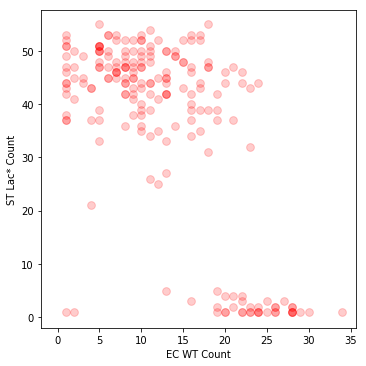

In [17]:
exp = experiment(100, 200)
exp.set_poisson(.75, .75)

new_rdiv = rdiv_n_n(.8, -.8, -4)
exp.set_a(0.542051564193, .05)
exp.set_a2a(1, .2, AX(-.8))
exp.set_b2a_neg(1, 1, AX(-4))

exp.set_b(0.215153136653, .05)
exp.set_b2b(1, .06, AX(1))
exp.set_a2b_neg(1, .05, AX(-20))

exp.simulate()
full_df = exp.pandas_trajectories()
results = full_df
sub_df = results[results['time'] == 99]
scatter_df = sub_df.pivot(index='dropID', values='cellcount', columns='celltype')
A_counts = scatter_df['A']
B_counts = scatter_df['B']

f, ax = plt.subplots(figsize=(5,5))
plt.scatter(A_counts, B_counts, c='red', alpha=0.2, s=60, edgecolor='red', label='model')

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_xlim([-2, x1])
ax.set_ylim([-2, y1])

plt.tight_layout()

plt.xlabel('EC WT Count')
plt.ylabel('ST Lac* Count')